In [1]:
"""
Keras

学習済のCNNを使用する。
VGG16モデルでデータ拡張を行わない高速な特徴抽出を行う。

This is modified version of the tutorial code in the Book "Deep Learning with Python"
Copyright 2017 by Manning Publications, Co.
https://github.com/fchollet/deep-learning-with-python-notebooks
Copyright (c) 2017 François Chollet
"""
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [2]:
#
# 学習済の畳み込みベースを使って特徴量を抽出する
#
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# ディレクトリ設定
base_dir = '~/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,
                                            target_size=(150, 150),
                                            batch_size=batch_size,
                                           class_mode='binary')
    i = 0
    for input_batch, labels_batch in generator:
        features_batch = conv_base.predict(input_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # ジェネレータはデータを無限ループで生成するため
            # 画像を一通り処理したらbreakしなければならない
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

# 特徴量の形状を (samples, 4, 4, 512) から (samples, 8192) に平坦化する
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
#
# 全結合分類器の定義と訓練
#
from keras import models, layers, optimizers

# モデルの定義
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# コンパイル
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

# 訓練
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 27s 13ms/step - loss: 0.5920 - acc: 0.6885 - val_loss: 0.4327 - val_acc: 0.8460
Epoch 2/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.4369 - acc: 0.8005 - val_loss: 0.3540 - val_acc: 0.8620
Epoch 3/30
2000/2000 [==============================] - 5s 3ms/step - loss: 0.3559 - acc: 0.8435 - val_loss: 0.3158 - val_acc: 0.8830
Epoch 4/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.3053 - acc: 0.8710 - val_loss: 0.2990 - val_acc: 0.8820
Epoch 5/30
2000/2000 [==============================] - 5s 2ms/step - loss: 0.2926 - acc: 0.8775 - val_loss: 0.2883 - val_acc: 0.8840
Epoch 6/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2649 - acc: 0.8895 - val_loss: 0.2694 - val_acc: 0.8970
Epoch 7/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2530 - acc: 0.9040 - val_loss: 0.2623 - val_acc: 0.8960
Epoch 8/30
2

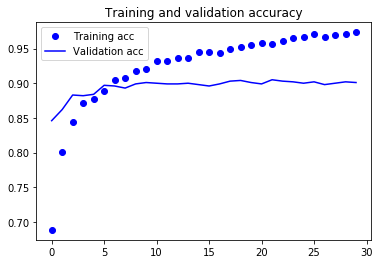

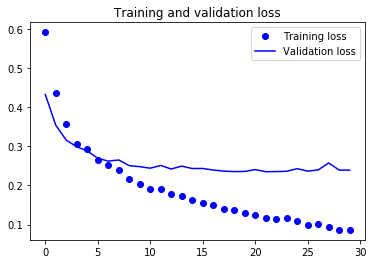

In [7]:
#
# 結果をプロット
#
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# 正解率をプロット
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# 損失値をプロット
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [8]:
# save the model
model.save('cats_and_dogs_small_3.h5')